In [2]:
import sys
import os

# Adiciona a pasta principal ao sys.path para podermos importar modulos de myutils
main_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
if main_path not in sys.path:
    sys.path.append(main_path)

# silenciar avisos do TF

os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_VLOG_LEVEL'] = '0'
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ["KERAS_BACKEND"] = "tensorflow"
# os.environ['CUDA_VISIBLE_DEVICES'] = ''

import tensorflow as tf
from tensorflow import keras as K
import numpy as np
import pandas as pd
import glob
import cv2
import albumentations as A
import matplotlib.pyplot as plt
import imtools
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve
# import data_wrangling as dw
import importlib
from absl import logging

# Define o nível de logging para silenciar os avisos do TF
tf.get_logger().setLevel('ERROR')
logging.set_verbosity(logging.ERROR)

device = tf.config.list_physical_devices('GPU')[0]
tf.config.experimental.set_memory_growth(device, True)

# CelebA dataset

a partir dos metadados de identidade, extraimos um dataframe com [path, id], onde cada id pertende a uma pessoa única

In [10]:
anno_dir = "../../data/celebA/identity_CelebA.txt"

df = pd.read_csv(anno_dir, sep=' ', header=None, names=['path', 'id']).sort_values('id').reset_index(drop=True)
uniques = df['id'].unique()
df

path     id
0       056279.png      1
1       145590.png      1
2       068169.png      1
3       000023.png      1
4       024091.png      1
...            ...    ...
202594  130636.png  10177
202595  129750.png  10177
202596  136615.png  10177
202597  053390.png  10177
202598  062371.png  10177

[202599 rows x 2 columns]

3406


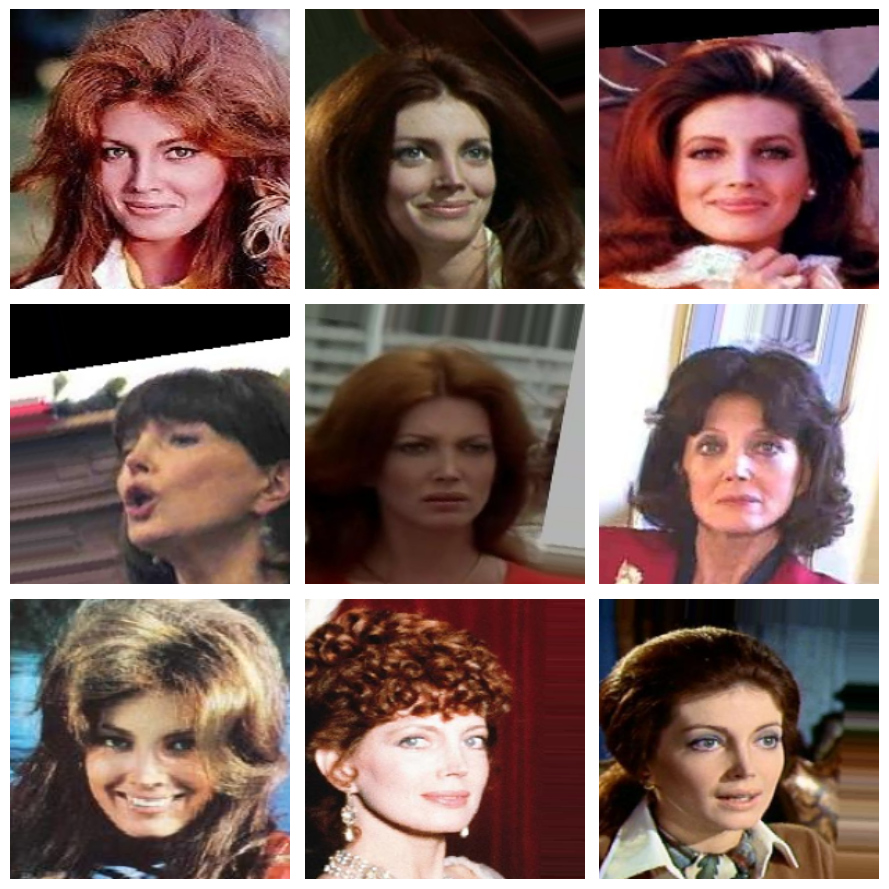

In [22]:
# visualizando todas as fotos de um id aleatório
id = np.random.choice(uniques, 1)[0]
random_person = df[df['id'] == id]
imgs = []
for i, row in random_person.iterrows():
    path = os.path.join("../../data/celebA/images/", row['path'])
    imgs.append(imtools.load_image(path))

print(id)
imtools.plot_grid(imgs, scale=3)

## Split data

In [122]:
from sklearn.model_selection import train_test_split


unique_ids = df['id'].unique()
train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=42)

train_df = df[df['id'].isin(train_ids)].reset_index(drop=True)
test_df = df[df['id'].isin(test_ids)].reset_index(drop=True)

# Augmentation

6625


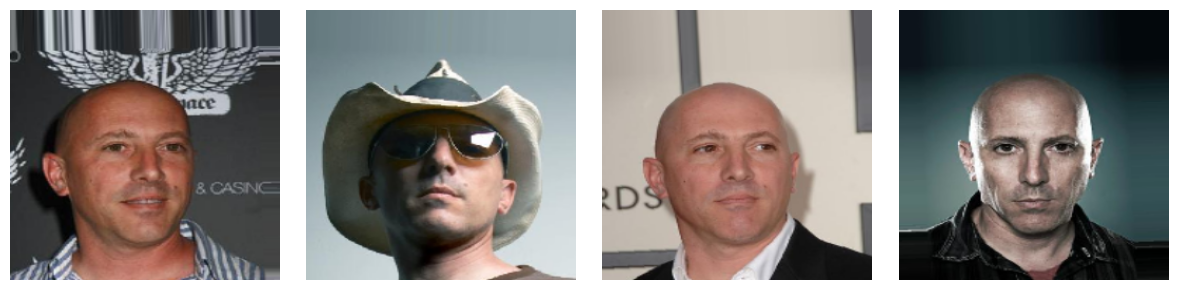

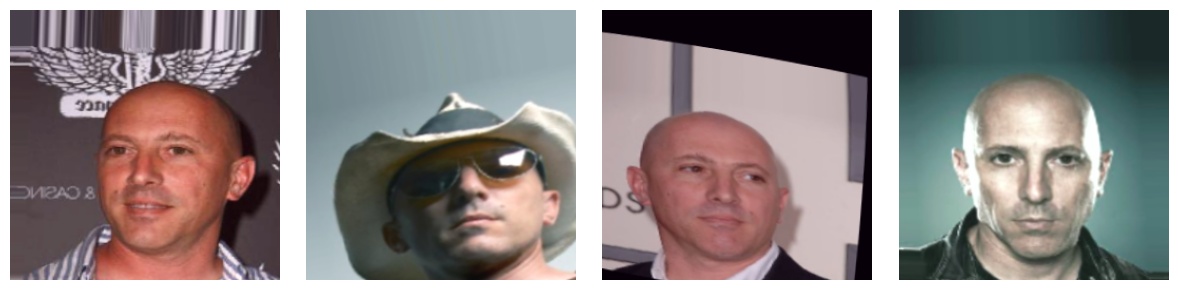

In [49]:
transform_train = A.Compose([    
    A.HorizontalFlip(p=0.5),
    A.Affine(scale=(0.75, 1.2), translate_percent=(-0.1, 0.1), rotate=(-15, 15), shear=(-10, 10), border_mode=1, p=0.8),
    A.RandomOrder([        
        A.CLAHE(),
        A.RandomBrightnessContrast(),
        A.GaussianBlur(3),
        A.GaussNoise(std_range=(0.005, 0.05)),
        A.OneOf([
            A.ToGray(),
            A.ToSepia(),            
        ]),
        A.OneOf([
            A.RGBShift((-20, 20), (-20, 20), (-20, 20)),
            A.ColorJitter(brightness=(0.95, 1.05), contrast=(0.95, 1.05), saturation=(0.95, 1.05), hue=(-0.05, 0.05))
        ]),
        A.GridDistortion(
            num_steps=3,
            distort_limit=[-0.1, 0.1],
            interpolation=cv2.INTER_LINEAR,
            normalized=True,
            mask_interpolation=cv2.INTER_NEAREST,
        ),
        A.OpticalDistortion(distort_limit=(-0.2, 0.2)),
        A.Perspective(scale=(0.01, 0.08)),
        A.Posterize(num_bits=(4, 7)),
        A.Defocus(radius=(1, 3)) 
    ], n=4),
    
])

transform_test = A.Compose([
    A.RandomOrder([
        A.HorizontalFlip(p=0.5),
        A.Affine(scale=(0.85, 1.1), translate_percent=(-0.1, 0.1), rotate=(-15, 15), shear=(-5, 5), border_mode=1, p=0.8),
        A.RGBShift((-10, 10), (-10, 10), (-10, 10)),
        A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.75),
        A.OpticalDistortion(distort_limit=(-0.1, 0.1), p=0.75),
        A.Perspective(scale=(0.01, 0.05), p=0.75),        
    ], n=4)
])

# funcões auxiliares para augmentation
augment_train = lambda img: transform_train(image=img)['image']
augment_test = lambda img: transform_test(image=img)['image']


######################
# Avaliando a qualidade da transformada
id = np.random.choice(uniques, 1)[0]
random_person = df[df['id'] == id]
imgs = []
imgs_auged = []
for i, row in random_person.iterrows():
    path = os.path.join("../../data/celebA/images/", row['path'])    
    img = imtools.load_image(path)
    imgs.append(img)
    imgs_auged.append(augment_test(img))

print(id)
n = len(imgs)
if n > 5:
    n = 5
imtools.plot_images(imgs[:n-1], scale=3)
imtools.plot_images(imgs_auged[:n-1], scale=3)

In [52]:
# triplet dataset
def get_dataset(anno_df, batch_size, kshots=1, img_size=224, transform=None, drop=False, shuffle=False):    
    def gen():        
        while True:
            positive_idx, negative_idx = np.random.choice(anno_df['id'], 2, replace=False)
            
            # path | id df
            positive_obs = anno_df[anno_df['id'] == positive_idx]
            negative_obs = anno_df[anno_df['id'] == negative_idx]

            # sortear K-shot dos suportes triplet
            positive_obs = positive_obs.sample(kshots+1, replace=True) # query é a amostra +1
            negative_obs = negative_obs.sample(kshots, replace=True)

            # separar query de positives
            query_obs = positive_obs.iloc[-1]
            positive_obs = positive_obs.iloc[:-1]
                        
            # carregar e guardar imagens em listas
            positive_imgs = []
            negative_imgs = []
            query_imgs = []
            for i, row in positive_obs.iterrows():
                path = os.path.join("../../data/celebA/images/", row['path'])
                positive_imgs.append(imtools.load_image(path, size=(img_size, img_size)))
            for i, row in negative_obs.iterrows():
                path = os.path.join("../../data/celebA/images/", row['path'])
                negative_imgs.append(imtools.load_image(path, size=(img_size, img_size)))

            # só há um query que será multiplicado com augmentation por Kshots
            path = os.path.join("../../data/celebA/images/", query_obs['path'])
            query_img = imtools.load_image(path, size=(img_size, img_size))

            # augmentation
            if transform is not None:
                positive_imgs = [transform(img) for img in positive_imgs]
                negative_imgs = [transform(img) for img in negative_imgs]
                query_imgs = [transform(query_img) for _ in range(kshots)] # multiplicando query com augmentation
            else: # repetir o query para preservar compatibilidade do output_signature
                query_imgs = [query_img for _ in range(kshots)]

            # to tensor
            p_inputs = np.array(positive_imgs).astype('float32')
            n_inputs = np.array(negative_imgs).astype('float32')
            q_inputs = np.array(query_imgs).astype('float32')
            
            yield p_inputs, n_inputs, q_inputs
    
    output_signature = (
        tf.TensorSpec(shape=(kshots, img_size, img_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(kshots, img_size, img_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(kshots, img_size, img_size, 3), dtype=tf.float32)
    )

    ds = tf.data.Dataset.from_generator(gen, output_signature=output_signature)
    ds = ds.shuffle(batch_size*8) if shuffle else ds
    ds = ds.batch(batch_size, drop_remainder=drop)
    ds = ds.prefetch(20)
    return ds

In [123]:
BATCH_SIZE = 16
KSHOTS = 5
train_ds = get_dataset(anno_df=train_df,
                       batch_size=BATCH_SIZE,
                       kshots=KSHOTS,
                       img_size=224,
                       transform=augment_train,
                       drop=True,
                       shuffle=False)

test_ds = get_dataset(anno_df=test_df,
                       batch_size=BATCH_SIZE,
                       kshots=KSHOTS,
                       img_size=224,
                       transform=augment_test,
                       drop=True,
                       shuffle=False)

(16, 5, 224, 224, 3) (16, 5, 224, 224, 3) (16, 5, 224, 224, 3)


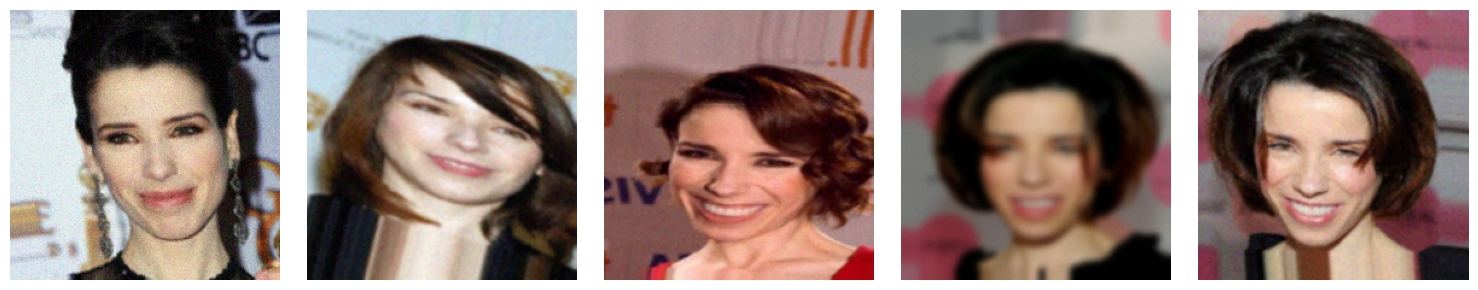

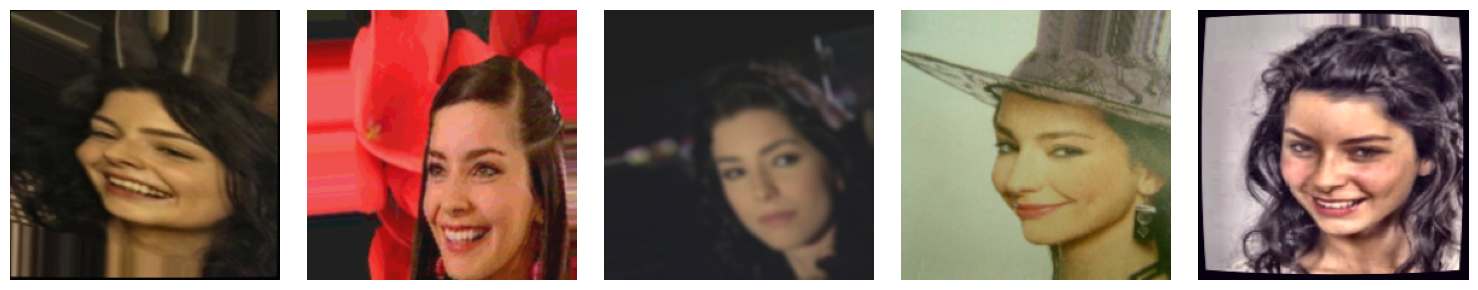

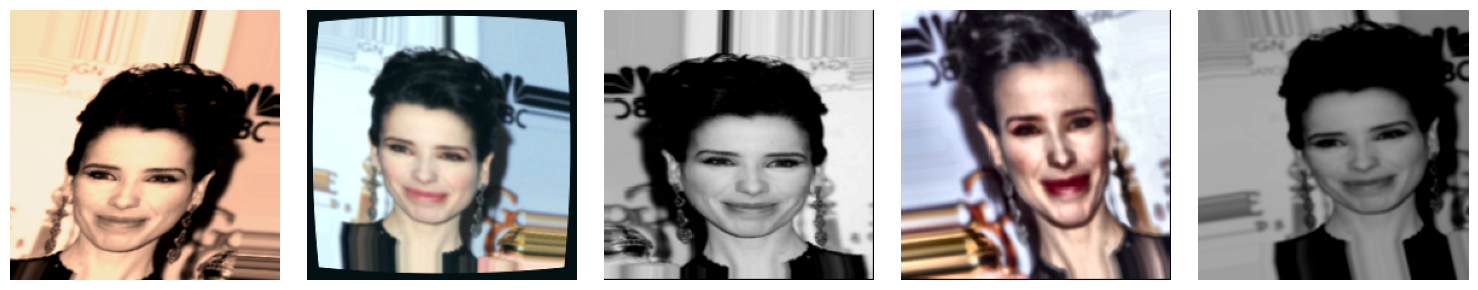

In [66]:
for P, N, Q in train_ds:
    break

print(P.shape, N.shape, Q.shape)

imtools.plot_images(P[0,].numpy().astype('uint8'), scale=3)
imtools.plot_images(N[0,].numpy().astype('uint8'), scale=3)
imtools.plot_images(Q[0,].numpy().astype('uint8'), scale=3)

## FaceModel

In [125]:
@K.utils.register_keras_serializable(package='Custom')
def l2norm(x):
    return tf.nn.l2_normalize(x, axis=1)


@K.utils.register_keras_serializable(package='Custom')
def build_feature_extractor(input_shape, backbone, dim=512):
    def self_attention(layer,):
        x = K.layers.Dropout(0.5)(layer)
        x = K.layers.Dense(dim // 2, activation='gelu')(x)
        att_mask = K.layers.Dense(dim, activation='sigmoid')(x)

        x = K.layers.Dropout(0.5)(layer)
        x = K.layers.Dense(dim)(x)

        return x * att_mask
    
    backbone.trainable = False
    
    inputs = K.layers.Input(shape=input_shape)

    # feature extraction
    embeddings = backbone(inputs, training=False)
    
    # vectorize
    x = K.layers.GlobalAveragePooling2D()(embeddings)
    x = self_attention(x)
    outputs = K.layers.Lambda(l2norm)(x)

    feature_extractor = K.Model(inputs, outputs)
    return feature_extractor


@K.utils.register_keras_serializable(package='Custom')
class FaceModel(K.Model):
    def __init__(self, feature_extractor, dim=512, **kwargs):
        super().__init__(**kwargs)
        self.feature_extractor=feature_extractor        
        self.dim=dim
        self.triplet_loss_tracker=K.metrics.Mean(name='loss')

    @property
    def metrics(self):
        return [
            self.triplet_loss_tracker,
        ]
    
    def compute_loss(self, p, n, q):
        "soft margin semi-hard negatives"

        p_dist = tf.reduce_sum(tf.square(p - q), axis=1) # (batch, dim) -> (batch,)
        n_dist = tf.reduce_sum(tf.square(n - q), axis=1)

        # dp < dn < dp + margin
        # mask = tf.logical_and(p_dist < n_dist, n_dist < (p_dist + self.margin)) # (batch, 1) bool

        diff = p_dist - n_dist # (batch,)
        soft_loss = tf.math.log1p(tf.exp(diff)) # (batch,)
        loss = soft_loss

        # manter apenas as distâncias moderadas
        # loss = tf.boolean_mask(soft_loss, mask) # (batch,)
        return tf.reduce_mean(loss) # em caso de mask ser all False TODO: VERIFICAR MÉDIA COM MASK 

    def train_step(self, data):
        with K.backend.name_scope('train'):                    
            p_episodes, n_episodes, q_episodes = data                                         
            num_episodes = p_episodes.shape[0] # equivalente ao batch_size            
                        
            with tf.GradientTape() as tape:
                # (batch, dim) vai armazenar todas as inferências de cada classe 
                # Criando TensorArrays dinâmicos
                p_batch_pred = tf.TensorArray(tf.float32, size=num_episodes)
                n_batch_pred = tf.TensorArray(tf.float32, size=num_episodes)
                q_batch_pred = tf.TensorArray(tf.float32, size=num_episodes)
                for episode in range(num_episodes): # (# batch iterações)
                    p_inputs, n_inputs, q_inputs = p_episodes[episode], n_episodes[episode], q_episodes[episode]

                    # transforma todas as entradas em um único batch de (3*kshots, H, W, 3)
                    inputs = tf.concat([p_inputs, n_inputs, q_inputs], axis=0) # (P + N + Q)
                    kshots = inputs.shape[0] // 3

                    # extração de todos os vetores
                    embeddings = self.feature_extractor(inputs)
                    
                    # split de cada classe
                    p_embeddings = embeddings[0:kshots]
                    n_embeddings = embeddings[kshots:2*kshots]
                    q_embeddings = embeddings[-kshots:]

                    # médias do K-shot
                    p_vector = tf.reduce_mean(p_embeddings, axis=0)
                    n_vector = tf.reduce_mean(n_embeddings, axis=0)
                    q_vector = tf.reduce_mean(q_embeddings, axis=0)

                    # preencher os tensores dinâmicos
                    p_batch_pred = p_batch_pred.write(episode, p_vector)
                    n_batch_pred = n_batch_pred.write(episode, n_vector)
                    q_batch_pred = q_batch_pred.write(episode, q_vector)
                    
                # após todas as inferências, recuperar o valor final (Batch, dim)
                p_batch_pred = p_batch_pred.stack()
                n_batch_pred = n_batch_pred.stack()
                q_batch_pred = q_batch_pred.stack()
                
                # soft margin semi-hard triplet loss
                loss = self.compute_loss(p_batch_pred, n_batch_pred, q_batch_pred)

            grads = tape.gradient(loss, self.feature_extractor.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.feature_extractor.trainable_weights))

            # atualizar trackers
            self.triplet_loss_tracker.update_state(loss)

        return {m.name: m.result() for m in self.metrics}
    
                
    def get_config(self):
        config = super().get_config()
        config.update({
            "feature_extractor": K.utils.serialize_keras_object(self.feature_extractor),
            "margin": self.margin,
            "dim": self.dim
        })
        return config

    @classmethod
    def from_config(cls, config):
        fe_ser = config.pop("feature_extractor")        
        feature_extractor = K.utils.deserialize_keras_object(fe_ser)
        
        margin = config.pop("margin", 0.2)
        dim = config.pop("dim", 512)

        return cls(feature_extractor=feature_extractor, margin=margin, dim=dim, **config)


# ----------------------------
# Build model
# ----------------------------
backbone = K.applications.EfficientNetB0(
    include_top=False,    
    weights='imagenet',
    input_shape=(224, 224, 3)
)
feature_extractor = build_feature_extractor((224, 224, 3), backbone, dim=512)
model = FaceModel(feature_extractor, dim=512)
model.compile(optimizer=K.optimizers.Adam(1e-3))

In [127]:
@K.utils.register_keras_serializable(package='Custom')
def l2norm(x):
    # Esta função aplica a normalização L2 em cada vetor de entrada.
    # Isso significa que cada vetor é ajustado para ter comprimento igual a 1.
    # Isso ajuda o modelo a comparar vetores de forma mais justa, sem depender da escala.
    return tf.nn.l2_normalize(x, axis=1)


@K.utils.register_keras_serializable(package='Custom')
def build_feature_extractor(input_shape, backbone, dim=512):
    # Esta função constrói um modelo que extrai o feature embedding
    # de uma imagem | imagem -> vetor.

    def self_attention(layer,):
        # Este bloco implementa uma forma simples de "atenção"
        # (um mecanismo que ajuda o modelo a focar nas partes mais importantes da imagem).
        
        # projeção linear sem ativação, para ajustar o número de dimensões
        res = K.layers.Dense(dim)(layer)
        x = K.layers.Dropout(0.1)(res)

        # transformação intermediária das features com redução de dimensionalidade
        x = K.layers.Dense(dim // 2, activation='gelu')(x)

        # Máscara de atenção — decide "onde olhar" nas features extraídas. 
        # Restaura a dimensionalidade original
        att_mask = K.layers.Dense(dim, activation='sigmoid')(x)        

        # Multiplica o vetor original (e projetado) pela máscara de atenção.
        # Isso destaca as partes mais relevantes.
        return res * att_mask
    
    # Congela os pesos do backbone (rede pré-treinada),
    # para usar apenas como feature extractor.
    backbone.trainable = False
    
    # ######################## construção do modelo ##################### #
    # ------------------------------------------------------------------- #    
    inputs = K.layers.Input(shape=input_shape)

    # Passa a imagem pelo backbone para extrair as features.
    embeddings = backbone(inputs, training=False) # (w, h, c)
    
    # Resume as features em um vetor (média global das ativações).
    x = K.layers.GlobalAveragePooling2D()(embeddings) # (c,)

    # Aplica o bloco de autoatenção nas features.
    x = self_attention(x)

    # Normaliza o vetor final (comprimento igual a 1).
    outputs = K.layers.Lambda(l2norm)(x)

    # modelo completo (image -> vector)
    feature_extractor = K.Model(inputs, outputs)
    return feature_extractor


@K.utils.register_keras_serializable(package='Custom')
class FaceModel(K.Model):
    # Este modelo usa o feature extractor para treinar com base em "triplets" de few-shot learning.
    # O objetivo é aprender a deixar rostos da mesma pessoa próximos
    # e rostos diferentes mais distantes no espaço vetorial.

    def __init__(self, feature_extractor, dim=512, **kwargs):
        super().__init__(**kwargs)
        self.feature_extractor=feature_extractor
        self.dim=dim
        self.triplet_loss_tracker=K.metrics.Mean(name='loss')

    @property
    def metrics(self):
        # Define quais métricas serão acompanhadas durante o treino.
        return [
            self.triplet_loss_tracker,
        ]
    
    def compute_loss(self, p, n, q):
        # Função que calcula a perda (loss) usando o método triplet loss.
        # espera todos os tensores em shape = (batch, dim) | médias dos few-shots
        # p = positivo (mesma pessoa) 
        # n = negativo (pessoa diferente)
        # q = consulta (imagem principal | âncora)

        p_dist = tf.reduce_sum(tf.square(p - q), axis=1) # distância entre p e q | (batch,) soma das dim diferenças
        n_dist = tf.reduce_sum(tf.square(n - q), axis=1) # distância entre n e q

        # A ideia é fazer dp < dn (positivos mais próximos que negativos).
        diff = p_dist - n_dist # (batch,)

        # Soft-margin: suaviza a penalização, evitando saltos bruscos na perda.
        soft_loss = tf.math.log1p(tf.exp(diff))        

        # Retorna a média das perdas no batch.
        return tf.reduce_mean(soft_loss) # (1,) média do batch

    def train_step(self, data):
        # Esta função define o que acontece em cada passo de treinamento.

        with K.backend.name_scope('train'):                    
            # Cada "episódio" contém trios de imagens: positivo, negativo e consulta.
            p_episodes, n_episodes, q_episodes = data # entregue pelo dataset                                   
            num_episodes = p_episodes.shape[0] # número de episódios no batch | equivalente ao tamanho do batch   
            
            with tf.GradientTape() as tape:
                # TensorArrays armazenam os vetores gerados em cada iteração.
                # formato necessário para operações tensoriais durante o treinamento.
                p_batch_pred = tf.TensorArray(tf.float32, size=num_episodes)
                n_batch_pred = tf.TensorArray(tf.float32, size=num_episodes)
                q_batch_pred = tf.TensorArray(tf.float32, size=num_episodes)

                # Itera sobre todos os episódios do batch.
                for episode in range(num_episodes): # se batch_size = 16... São 16 episódios
                    # todas as imagens de um único episódio (k-shots de cada classe)
                    p_inputs, n_inputs, q_inputs = p_episodes[episode], n_episodes[episode], q_episodes[episode] # todos com (K, W, H, C)

                    # Junta todas as imagens do episódio em um único batch de predict.
                    # para aproveitar a paralelização da GPU
                    inputs = tf.concat([p_inputs, n_inputs, q_inputs], axis=0) # (3*K, W, H, C) 
                    kshots = inputs.shape[0] // 3  # número de amostras por classe. Por isso o ds tem que ser padrão

                    # Extrai os vetores (embeddings) das imagens.
                    embeddings = self.feature_extractor(inputs) # (3*K, dim) 
                    
                    # Separa os embeddings em três grupos.
                    p_embeddings = embeddings[0:kshots]         # (K, dim)
                    n_embeddings = embeddings[kshots:2*kshots]  # (K, dim)
                    q_embeddings = embeddings[-kshots:]         # (K, dim)

                    # Calcula a média dos embeddings (para o caso de few-shot | contra 1-shot).
                    p_vector = tf.reduce_mean(p_embeddings, axis=0) # (dim,)
                    n_vector = tf.reduce_mean(n_embeddings, axis=0) # (dim,)
                    q_vector = tf.reduce_mean(q_embeddings, axis=0) # (dim,)

                    # Guarda os vetores de cada episódio.
                    # é isso que permite o backpropagation funcionar.
                    p_batch_pred = p_batch_pred.write(episode, p_vector)
                    n_batch_pred = n_batch_pred.write(episode, n_vector)
                    q_batch_pred = q_batch_pred.write(episode, q_vector)
                    
                # Após terminar o loop de episódios,
                # empilha todos os resultados em um único tensor (Batch, dim)
                p_batch_pred = p_batch_pred.stack()
                n_batch_pred = n_batch_pred.stack()
                q_batch_pred = q_batch_pred.stack()
                
                # Calcula a perda final usando a triplet loss softmargin.
                loss = self.compute_loss(p_batch_pred, n_batch_pred, q_batch_pred)

            # Calcula os gradientes da perda em relação aos pesos treináveis.
            grads = tape.gradient(loss, self.feature_extractor.trainable_weights)

            # Atualiza os pesos do modelo com base nos gradientes.
            self.optimizer.apply_gradients(zip(grads, self.feature_extractor.trainable_weights))

            # Atualiza a métrica de perda média.
            self.triplet_loss_tracker.update_state(loss)

        # Retorna as métricas atuais.
        return {m.name: m.result() for m in self.metrics}
    
                
    def get_config(self):
        # Salva a configuração do modelo (necessário para exportar e reusar).
        config = super().get_config()
        config.update({
            "feature_extractor": K.utils.serialize_keras_object(self.feature_extractor),
            # "margin": self.margin,
            "dim": self.dim
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Restaura o modelo a partir de uma configuração salva.
        fe_ser = config.pop("feature_extractor")        
        feature_extractor = K.utils.deserialize_keras_object(fe_ser)
        
        dim = config.pop("dim", 512)

        return cls(feature_extractor=feature_extractor, dim=dim, **config)


# ----------------------------
# Construção do modelo
# ----------------------------

# Carrega uma rede pré-treinada (EfficientNetB0) sem a camada final.
# Ela será usada como extratora de características.
backbone = K.applications.EfficientNetB0(
    include_top=False,    
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# Cria o modelo preparado para treinamento few-shot com softmargin triplet loss.
feature_extractor = build_feature_extractor((224, 224, 3), backbone, dim=512)
model = FaceModel(feature_extractor, dim=512)
model.compile(optimizer=K.optimizers.Adam(1e-3))


## callbacks

In [134]:
def compute_metrics(p, n, q):
    p_dist = tf.reduce_sum(tf.square(p - q), axis=1) # (batch, dim) -> (batch,)
    n_dist = tf.reduce_sum(tf.square(n - q), axis=1)

    # distâncias negativas para melhor interpretabilidade das métricas
    # "quanto maior -d, mais parecido com o positivo"
    scores = -tf.concat([p_dist, n_dist], axis=0).numpy()                  # y_pred
    labels = tf.concat([np.ones_like(p_dist), np.zeros_like(n_dist)], axis=0).numpy() # y_true
    
    auroc = roc_auc_score(labels, scores)           # ROC-AUC
    aupr  = average_precision_score(labels, scores) # PR-AUC

    # Youlden's J threshold
    # encontra o threshold que maximiza a diferença TPR - FPR
    fpr, tpr, thresholds = roc_curve(labels, scores)
    J = tpr - fpr
    idx = np.argmax(J)
    J_threshold = thresholds[idx]

    return auroc, aupr, fpr, tpr, J_threshold


class VerificationMetrics(K.callbacks.Callback):
    def __init__(self, val_ds, compute_fn, steps=10):
        super().__init__()
        self.val_ds = val_ds        
        self.compute_fn = compute_fn
        self.steps = steps
        self.loss_tracker = K.metrics.Mean(name='loss')
        self.auroc_tracker = K.metrics.Mean(name='auroc')
        self.aupr_tracker = K.metrics.Mean(name='aupr')
        self.threshold_tracker = K.metrics.Mean(name='threshold')

    def compute_loss(self, p, n, q):
        "soft margin semi-hard negatives"

        p_dist = tf.reduce_sum(tf.square(p - q), axis=1) # (batch, dim) -> (batch,)
        n_dist = tf.reduce_sum(tf.square(n - q), axis=1)

        diff = p_dist - n_dist # (batch,)
        soft_loss = tf.math.log1p(tf.exp(diff)) # (batch,)
        loss = soft_loss
        
        return tf.reduce_mean(loss)

    def on_epoch_end(self, epoch, logs=None):
        counter = 0
        for p_episodes, n_episodes, q_episodes in self.val_ds:
            num_episodes = p_episodes.shape[0]
            p_batch_pred = tf.TensorArray(tf.float32, size=num_episodes)
            n_batch_pred = tf.TensorArray(tf.float32, size=num_episodes)
            q_batch_pred = tf.TensorArray(tf.float32, size=num_episodes)
            for episode in range(num_episodes): # (# batch iterações)
                p_inputs, n_inputs, q_inputs = p_episodes[episode], n_episodes[episode], q_episodes[episode]

                # transforma todas as entradas em um único batch de (3*kshots, H, W, 3)
                inputs = tf.concat([p_inputs, n_inputs, q_inputs], axis=0) # (P + N + Q)
                kshots = inputs.shape[0] // 3

                # extração de todos os vetores
                embeddings = self.model.feature_extractor(inputs)
                
                # split de cada classe
                p_embeddings = embeddings[0:kshots]
                n_embeddings = embeddings[kshots:2*kshots]
                q_embeddings = embeddings[-kshots:]

                # médias do K-shot
                p_vector = tf.reduce_mean(p_embeddings, axis=0)
                n_vector = tf.reduce_mean(n_embeddings, axis=0)
                q_vector = tf.reduce_mean(q_embeddings, axis=0)

                # preencher os tensores dinâmicos
                p_batch_pred = p_batch_pred.write(episode, p_vector)
                n_batch_pred = n_batch_pred.write(episode, n_vector)
                q_batch_pred = q_batch_pred.write(episode, q_vector)
                
            # após todas as inferências, recuperar o valor final (Batch, dim)
            p_batch_pred = p_batch_pred.stack()
            n_batch_pred = n_batch_pred.stack()
            q_batch_pred = q_batch_pred.stack()
            
            # soft margin semi-hard triplet loss
            loss = self.compute_loss(p_batch_pred, n_batch_pred, q_batch_pred)

            auroc, aupr, fpr, tpr, J_threshold = self.compute_fn(p_batch_pred, n_batch_pred, q_batch_pred)

            self.loss_tracker.update_state(loss)
            self.auroc_tracker.update_state(auroc)
            self.aupr_tracker.update_state(aupr)
            self.threshold_tracker.update_state(J_threshold)

            counter += 1

            if counter == self.steps:
                break

        loss = self.loss_tracker.result()
        auroc = self.auroc_tracker.result()
        aupr = self.aupr_tracker.result()
        J_threshold = self.threshold_tracker.result()

        # print(f" | Epoch {epoch+1} | AUROC: {auroc:.4f} | AUPR: {aupr:.4f} | J_th: {J_threshold:.4f}")
        logs = logs or {}
        logs['val_loss'] = loss.numpy()
        logs['val_auroc'] = auroc.numpy()
        logs['val_aupr'] = aupr.numpy()
        logs['val_J_threshold'] = J_threshold.numpy()

# callback para iniciar com um LR baixo, aumentar, e voltar a descer
class WarmUpLearningRateScheduler(K.callbacks.Callback):
    """
    Callback de Learning Rate Scheduler com Warmup.
    
    Args:
        base_lr (float): taxa de aprendizado alvo após o warmup.
        warmup_epochs (int): número de épocas para aquecimento (warmup).        
    """
    def __init__(self, base_lr, warmup_epochs=5):
        super().__init__()
        self.base_lr = base_lr
        self.warmup_epochs = warmup_epochs

    def on_epoch_begin(self, epoch, logs=None):
        if epoch < self.warmup_epochs:
            # aumenta linearmente do 0 até base_lr
            lr = self.base_lr * (epoch + 1) / self.warmup_epochs
            
            self.model.optimizer.learning_rate = lr
            print(f"\n[WarmUpLR] Epoch {epoch+1}: ajustando learning rate para {lr:.6f}")

# se a loss não melhorar após 10 épocas seguidas, diminua o LR por 50%
lrOnPlateau = K.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-6
)

checkpoint = K.callbacks.ModelCheckpoint(
    'models/facerec_model_v2.keras',
    monitor = 'val_loss',
    save_best_only=True
)

earlystopping = K.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

tensorboard = K.callbacks.TensorBoard('logs')

callbacks = [
    VerificationMetrics(test_ds, compute_metrics, steps=13),
    WarmUpLearningRateScheduler(base_lr=1e-3, warmup_epochs=5),
    lrOnPlateau,
    checkpoint,
    earlystopping,
    tensorboard
]    

In [74]:
model.save('models/model_temp.keras')
model = K.models.load_model('models/model_temp.keras')

In [146]:
history = model.fit(
    train_ds,    
    epochs=300,
    steps_per_epoch=65,
    callbacks=callbacks
)
history = pd.DataFrame(history.history)


[WarmUpLR] Epoch 1: ajustando learning rate para 0.000200
Epoch 1/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 722ms/step - loss: 0.3354

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_api.py:102: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


65/65 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - loss: 0.3355 - val_loss: 0.3068 - val_auroc: 0.9069 - val_aupr: 0.8940 - val_J_threshold: -0.5150 - learning_rate: 2.0000e-04

[WarmUpLR] Epoch 2: ajustando learning rate para 0.000400
Epoch 2/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - loss: 0.3248 - val_loss: 0.3102 - val_auroc: 0.9062 - val_aupr: 0.8952 - val_J_threshold: -0.5427 - learning_rate: 4.0000e-04

[WarmUpLR] Epoch 3: ajustando learning rate para 0.000600
Epoch 3/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - loss: 0.3437 - val_loss: 0.3153 - val_auroc: 0.8999 - val_aupr: 0.8874 - val_J_threshold: -0.5604 - learning_rate: 6.0000e-04

[WarmUpLR] Epoch 4: ajustando learning rate para 0.000800
Epoch 4/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - loss: 0.3293 - val_loss: 0.3137 - val_auroc: 0.8973 - val_aupr: 0.8804 - val_J_threshold: -0.5944 - learning_rate: 8.0000e-04

[WarmUpLR] Epoch 5: ajustando learning rate para 0.001000
Epoch 5/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - loss: 0

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_api.py:102: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


65/65 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - loss: 0.3093 - val_loss: 0.3061 - val_auroc: 0.9004 - val_aupr: 0.8846 - val_J_threshold: -0.5903 - learning_rate: 0.0010
Epoch 8/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - loss: 0.3544 - val_loss: 0.3067 - val_auroc: 0.9011 - val_aupr: 0.8862 - val_J_threshold: -0.5672 - learning_rate: 0.0010
Epoch 9/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - loss: 0.3379 - val_loss: 0.3108 - val_auroc: 0.8994 - val_aupr: 0.8853 - val_J_threshold: -0.5511 - learning_rate: 0.0010
Epoch 10/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - loss: 0.3505 - val_loss: 0.3114 - val_auroc: 0.8991 - val_aupr: 0.8846 - val_J_threshold: -0.5381 - learning_rate: 0.0010
Epoch 11/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - loss: 0.3192 - val_loss: 0.3076 - val_auroc: 0.9020 - val_aupr: 0.8880 - val_J_threshold: -0.5410 - learning_rate: 0.0010
Epoch 12/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - loss: 0.3505 - val_loss: 0.3068 - val_auroc: 0.9029 - val_aupr: 0.8891 - val_J_th

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_api.py:102: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


65/65 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - loss: 0.3162 - val_loss: 0.3056 - val_auroc: 0.9037 - val_aupr: 0.8895 - val_J_threshold: -0.5468 - learning_rate: 0.0010
Epoch 14/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - loss: 0.3350 - val_loss: 0.3066 - val_auroc: 0.9032 - val_aupr: 0.8900 - val_J_threshold: -0.5402 - learning_rate: 0.0010
Epoch 15/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - loss: 0.3271 - val_loss: 0.3063 - val_auroc: 0.9034 - val_aupr: 0.8895 - val_J_threshold: -0.5444 - learning_rate: 0.0010
Epoch 16/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - loss: 0.3238 - val_loss: 0.3060 - val_auroc: 0.9041 - val_aupr: 0.8905 - val_J_threshold: -0.5440 - learning_rate: 0.0010
Epoch 17/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - loss: 0.3167 - val_loss: 0.3061 - val_auroc: 0.9035 - val_aupr: 0.8897 - val_J_threshold: -0.5485 - learning_rate: 0.0010
Epoch 18/300
65/65 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - loss: 0.3423 - val_loss: 0.3071 - val_auroc: 0.9032 - val_aupr: 0.8899 - val_J_

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
--------------------
P dist: -0.1484 | N dist: -0.7888


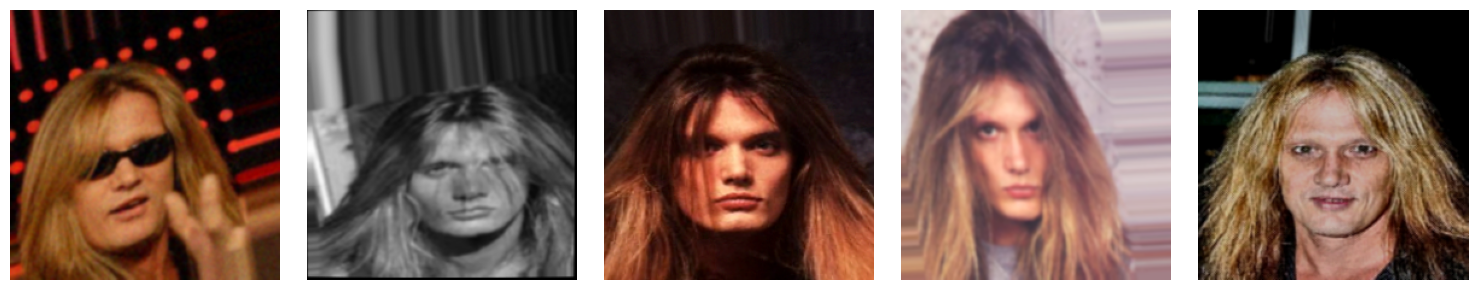

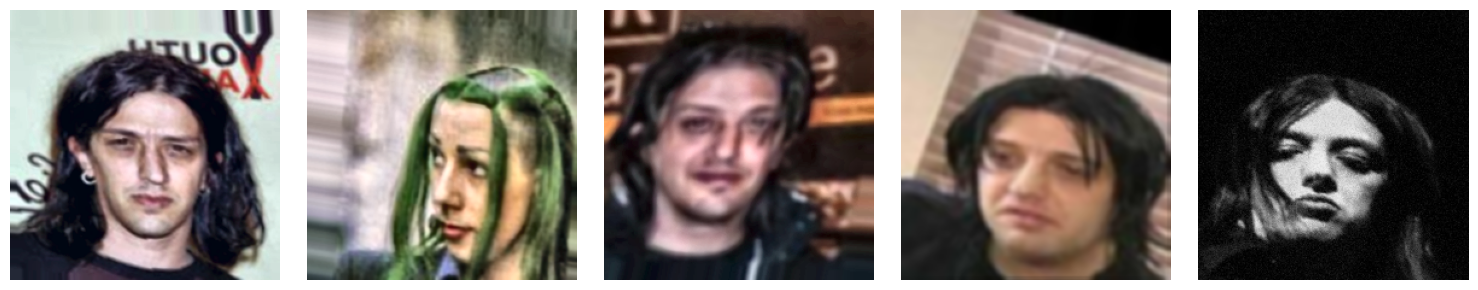

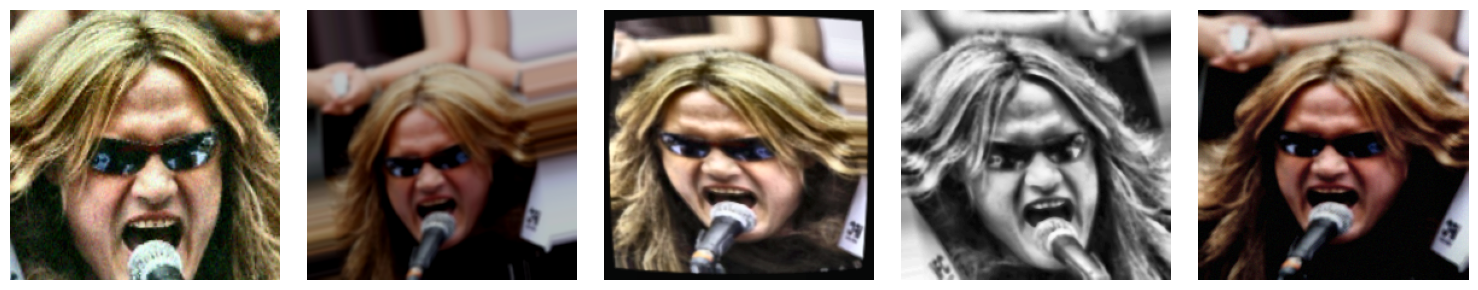

--------------------


In [145]:
for P, N, Q in train_ds:
    P, N, Q = P[0], N[0], Q[0]

    p_vector = model.feature_extractor.predict(P) # (K, dim)
    n_vector = model.feature_extractor.predict(N)
    q_vector = model.feature_extractor.predict(Q)

    p_vector = tf.reduce_mean(p_vector, axis=0) # (dim,)
    n_vector = tf.reduce_mean(n_vector, axis=0)
    q_vector = tf.reduce_mean(q_vector, axis=0)

    p_dist = -tf.reduce_sum(tf.square(p_vector - q_vector)) # (1,)
    n_dist = -tf.reduce_sum(tf.square(n_vector - q_vector))

    print("-"*20)
    print(f"P dist: {p_dist:.4f} | N dist: {n_dist:.4f}")
    imtools.plot_images(P.numpy().astype('uint8'), scale=3)
    imtools.plot_images(N.numpy().astype('uint8'), scale=3)
    imtools.plot_images(Q.numpy().astype('uint8'), scale=3)
    print("-"*20)

    break